In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from IPython.display import Image
from PIL import Image
import io
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [2]:
# Mount to Google Drive so images in Drive can be accessed by Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Read CSV file that contains corresponding item data
data = pd.read_csv('/content/drive/MyDrive/depop_item_details_complete.csv')
data = data.drop(columns=['Image', 'Date', 'Location'])
data.head()

,Description,Price listed,Price sold,Size,Brand
0,🌫️ Vintage hot pink sweater 🌫️ ▫️ Stretchy hot...,US$20.00,US$11.00,M,Cache
1,🌫️ Wool pencil skirt 🌫️ ▫️ Grey wool fabric sh...,US$15.00,US$4.50,4,Ralph Lauren
2,🌫️ Green and Black corset🌫️ ▫️ Gorge iridescen...,US$14.00,US$7.00,30,Other
3,🌫️ Vintage denim mini skirt 🌫️ ▫️ Lighter weig...,US$20.00,US$6.00,6,Calvin Klein
4,🌫️ Wide leg y2k pants 🌫️ ▫️ Thick black fabric...,US$20.00,US$14.00,8,American Vintage


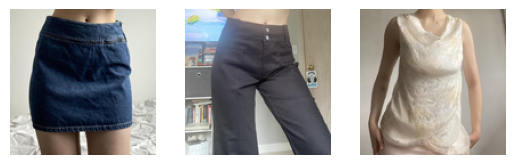

In [5]:
# Show example images to check format and quality
indices = np.array(data.index)
plt.figure()
# For each image, retrieve RGB matrix from Google Drive
for i in indices[3:6]:

    # Open the JPEG file
    rgb_matrix = np.load("/content/drive/MyDrive/depop_images/depop_image_" + str(i) + ".npy")

    # Change image to PIL format for in-cell display
    image = Image.fromarray(np.uint8(rgb_matrix))

    # Display the image in the notebook
    plt.subplot(1, 3, i-2)
    plt.imshow(image)
    plt.axis('off')

In [6]:
# Prices pulled from Depop are strings and have undesired 'US$', let's change them to floats for easier calculations
def pricing(price):
    """
    Reformat scraped Depop prices to floats.

    Parameters:
    price (string): Price string from Depop.

    Returns:
    price (float): Price as a float.
    """
    try:
      return float(price.replace('US$', ''))

    except ValueError:
      return price

# Apply pricing function
data['Price listed'] = data['Price listed'].apply(pricing)
data['Price sold'] = data['Price sold'].apply(pricing)

In [7]:
# Sizes pulled from Depop vary too greatly to be useful to NN, so we implement a simple sizing scheme
def sizing(size):
    """
    Find and replace numbered sizing (in womens clothing) and replace values with more discrete sizing scheme.

    Parameters:
    size (string): Raw size string from Depop.

    Returns:
    size (string): Size string converted in scheme.
    """
    try:
      # If size is number, it can be converted into a float, and therefore needs a category defined by the scheme below
      size = float(size)
      if size <= 4:
        return 'XS'

      elif size <= 8 or size == 26: # Note, the 26 is accounting for a pair of jeans in my particular dataset
        return 'S'

      elif size <= 12:
        return 'M'

      elif size <= 16 or size == 30: # Note, the 30 is accounting for a corset in my particular dataset
        return 'L'

      else:
        return 'XL'

    except ValueError:
      # If size isn't a number and contains 'US', it is a shoe
      # Handling this under scheme for now, but should potentially be changed to cater towards shoes (rather than clothing)
      if 'US ' in size:
        size = size.replace('US ', '')

        try:
          return sizing(float(size))

        except ValueError:
          return size

      else:
        return size

# Apply sizing function
data['Size'] = data['Size'].apply(sizing)

In [8]:
import torchvision.transforms as transforms

# Define transform function to convert image to tensor of proper dimensions
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

# Initialize input_images array to store RGB matrices
input_images = []

# Load each RGB matrix and add to input_images array
for i in indices:
  rgb_matrix = np.load("/content/drive/MyDrive/depop_images/depop_image_" + str(i) + ".npy")
  input_images.append(transform(rgb_matrix))

# Add Image column to data
data['Image'] = input_images

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert descriptions to TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
description_vectors = vectorizer.fit_transform(data['Description'])

# Convert the sparse matrix to a dense format (e.g., numpy array)
description_vectors = description_vectors.toarray()

# Add the vectors to the DataFrame
data['Description'] = list(description_vectors)

In [10]:
from sklearn.preprocessing import StandardScaler

# Scale Price listed values to help neural network
scaler = StandardScaler()
data['Price listed'] = scaler.fit_transform(data['Price listed'].values.reshape(-1, 1))

# Perform one-hot encoding on Size and Brand columns
data = pd.get_dummies(data, columns=['Size', 'Brand'])

In [11]:
# Define dataset
class DepopDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

        # Extract Size and Brand columns
        self.size_columns = dataframe.filter(like='Size').columns
        self.brand_columns = dataframe.filter(like='Brand').columns

        # Convert True/False to 0/1
        self.dataframe[self.size_columns] = self.dataframe[self.size_columns].astype(int)
        self.dataframe[self.brand_columns] = self.dataframe[self.brand_columns].astype(int)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Extract image, description, and numerical data
        image = torch.tensor(self.dataframe['Image'].iloc[idx], dtype=torch.float32)  # Image as tensor
        description = torch.tensor(self.dataframe['Description'].iloc[idx], dtype=torch.float32)  # Description

        # Extract price
        price_listed = torch.tensor([self.dataframe['Price listed'].iloc[idx]], dtype=torch.float32)

        # Extract one-hot encoded size and brand columns
        size = torch.tensor(self.dataframe[self.size_columns].iloc[idx].values, dtype=torch.float32)
        brand = torch.tensor(self.dataframe[self.brand_columns].iloc[idx].values, dtype=torch.float32)

        # Concatenate all inputs together
        combined_input = torch.cat([image.view(-1), description.view(-1), price_listed, size, brand], dim=0)

        # Label is the price sold
        label = torch.tensor(self.dataframe['Price sold'].iloc[idx], dtype=torch.float32)

        return combined_input, label

In [12]:
from sklearn.model_selection import train_test_split

# Split the dataset into training + validation and test sets
train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)  # 80% train/validation, 20% test

# Split the training + validation into training and validation sets
train_data, val_data = train_test_split(train_val_data, test_size=0.25, random_state=42)  # 60% train, 20% val (of the original data)

# Create Dataset instances for each split
train_dataset = DepopDataset(train_data)
val_dataset = DepopDataset(val_data)
test_dataset = DepopDataset(test_data)

# Define batch size
batch_size = 10

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify dimensions of each dataset
train_inputs, train_labels = next(iter(train_loader))
val_inputs, val_labels = next(iter(val_loader))
test_inputs, test_labels = next(iter(test_loader))
print("Dimensions of train data: ", train_inputs.shape)
print("Dimensions of validation data: ", val_inputs.shape)
print("Dimensions of test data: ", test_inputs.shape)

Dimensions of train data:  torch.Size([10, 50314])
Dimensions of validation data:  torch.Size([10, 50314])
Dimensions of test data:  torch.Size([10, 50314])


<ipython-input-11-721561ae3612>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(self.dataframe['Image'].iloc[idx], dtype=torch.float32)  # Image as tensor


In [52]:
# Initialize Training Loss and Validation Accuracy list
train_loss_list = []
val_loss_list = []

In [53]:
# Define the Neural Network Architecture
class DepopPriceNN(nn.Module):
    def __init__(self, input_size):
        super(DepopPriceNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)

        self.dropout = nn.Dropout(0.2)            # Dropout layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return x

# Determine the input size based on your combined input shape
input_size = 128*128*3 + 1000 + 1 + 15 + 146  # Note this is catered to my dataset

# Initialize the Model, Loss Function, and Optimizer
model = DepopPriceNN(input_size)  # Initialize the model
criterion = nn.MSELoss()                # Loss function for regression
optimizer = optim.Adam(model.parameters(), lr=0.00001)  # Optimizer

# Training Loop with Validation
num_epochs = 20  # Set the number of epochs for training
for epoch in range(num_epochs):
    # Training phase
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        train_loss_list.append(loss.item())
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels.view(-1, 1)).item()

        val_loss_list.append(val_loss / len(val_loader))

    avg_val_loss = val_loss / len(val_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')

<ipython-input-11-721561ae3612>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(self.dataframe['Image'].iloc[idx], dtype=torch.float32)  # Image as tensor


Epoch [1/20], Train Loss: 214.3178
Epoch [1/20], Validation Loss: 278.6385
Epoch [2/20], Train Loss: 453.9571
Epoch [2/20], Validation Loss: 237.8540
Epoch [3/20], Train Loss: 88.5522
Epoch [3/20], Validation Loss: 188.3032
Epoch [4/20], Train Loss: 177.7982
Epoch [4/20], Validation Loss: 150.9216
Epoch [5/20], Train Loss: 118.2181
Epoch [5/20], Validation Loss: 132.4802
Epoch [6/20], Train Loss: 886.3837
Epoch [6/20], Validation Loss: 126.7219
Epoch [7/20], Train Loss: 163.1516
Epoch [7/20], Validation Loss: 122.8333
Epoch [8/20], Train Loss: 60.8862
Epoch [8/20], Validation Loss: 120.1479
Epoch [9/20], Train Loss: 47.3586
Epoch [9/20], Validation Loss: 117.7011
Epoch [10/20], Train Loss: 540.6169
Epoch [10/20], Validation Loss: 115.2334
Epoch [11/20], Train Loss: 53.9750
Epoch [11/20], Validation Loss: 111.8850
Epoch [12/20], Train Loss: 127.0043
Epoch [12/20], Validation Loss: 110.1249
Epoch [13/20], Train Loss: 463.3210
Epoch [13/20], Validation Loss: 110.2143
Epoch [14/20], Train 

Text(0.5, 0, 'Epochs')

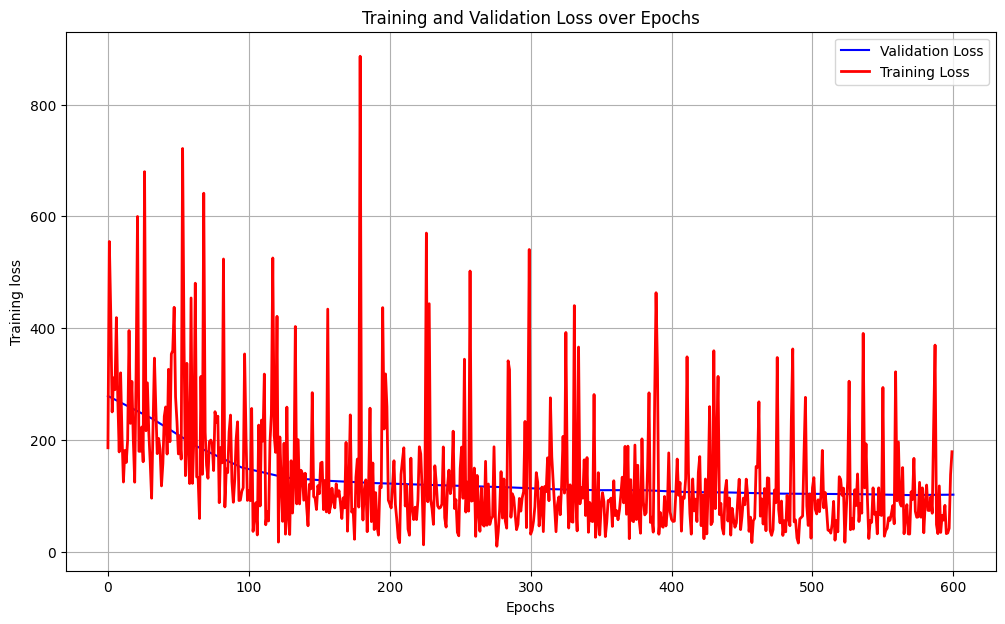

In [54]:
# Plots the training loss and validation accuracy
plt.figure(figsize = (12, 7))
plt.plot(np.linspace(0, 600, 20), val_loss_list, color = 'blue')
plt.plot(train_loss_list, linewidth = 2, color = 'red')
plt.legend(['Validation Loss', 'Training Loss'])
plt.title('Training and Validation Loss over Epochs')
plt.grid(True)
plt.ylabel("Training loss")
plt.xlabel("Epochs")

In [55]:
#Testing the Neural Network
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
predictions = []
actuals = []

with torch.no_grad():  # No need to compute gradients during testing
    for test_inputs, test_labels in test_loader:  # Use the test DataLoader
        test_outputs = model(test_inputs)  # Get model predictions
        loss = criterion(test_outputs, test_labels.view(-1, 1))  # Calculate test loss
        test_loss += loss.item()  # Accumulate test loss

        # Save predictions and actual labels for further evaluation
        predictions.extend(test_outputs.cpu().numpy())
        actuals.extend(test_labels.cpu().numpy())

# Average test loss over the entire test dataset
avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.4f}')

<ipython-input-11-721561ae3612>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(self.dataframe['Image'].iloc[idx], dtype=torch.float32)  # Image as tensor


Test Loss: 105.2701


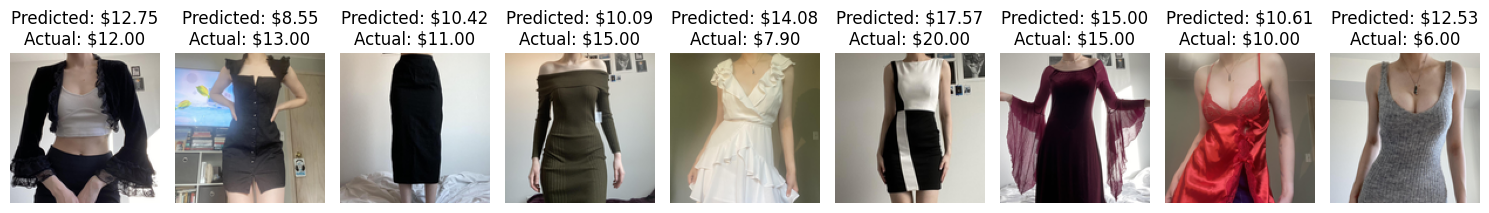

In [56]:
# Now we'll visualize model performance
num_samples = len(test_inputs)  # Adjust based on how many you want to see
real_values = actuals[:num_samples]
predicted_values = predictions[:num_samples]

# Define the mean and std values used for normalization
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

# Function to reverse normalization
def reverse_normalize(tensor):
    return tensor * std[:, None, None] + mean[:, None, None]

plt.figure(figsize=(15, 10))

for i, input  in enumerate(test_inputs):
    image_tensor = input[:128*128*3]  # Extract the features for the idx
    image = image_tensor.view(3, 128, 128)  # Reshape to (C, H, W)
    image = reverse_normalize(image)  # Apply reverse normalization
    actual_price = real_values[i].item()  # Ensure it's a scalar
    predicted_price = predicted_values[i].item()  # Ensure it's a scalar

    # Transpose to HxWxC for visualization
    image = image.permute(1, 2, 0).cpu().numpy()  # Convert to HxWxC for plt.imshow

    # Plotting
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(image)  # Display the image
    plt.axis('off')  # Hide axes
    plt.title(f'Predicted: ${predicted_price:.2f}\nActual: ${actual_price:.2f}')  # Show prices

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [57]:
def calculate_mape(predictions, actuals):
    """
    Calculate Mean Absolute Percentage Error (MAPE).

    Parameters:
    actuals (tensor): Actual prices (ground truth).
    predictions (tensor): Predicted prices by the model.

    Returns:
    mape (float): MAPE value as a percentage.
    """
    epsilon = 1e-12  # Small value to prevent division by zero
    percentage_error = torch.abs((actuals - predictions) / (actuals + epsilon)) * 100
    mape = percentage_error.mean().item()  # Take the average over all predictions
    return mape

In [58]:
calculate_mape(torch.tensor(predictions),torch.tensor(actuals))

70.8802719116211